# MC approaches

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from time import perf_counter

Let us first implement Black-Scholes formula whose result will be compared with the Asian call prices we find, for information.

In [3]:
def vanilla(
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> float:
    '''Returns the price of a vanilla call with the specified parameters under Black-Scholes model'''
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

## 1. Naive approach

In [4]:
def naive(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float, float]:  # returns the estimation and the half-length of the 95% confidence interval
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1).reshape((m + 1, 1))
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    means = s[:-1, ::].mean(axis=0)             # estimatation of the mean value of the underlying
    c = np.exp(-r*T)*np.maximum(means - K, 0)   # price for each simulation
    return c.mean(), 1.96*c.std()/np.sqrt(n)

### Results for varying strike $K$

In [125]:
fixed_n, fixed_m, fixed_r, fixed_S0 = 10**4, 100, .03, 100
Ks = np.linspace(90, 110, 11)

start = perf_counter()

result = {}
for fixed_T in [1/12, 1]:
    for fixed_sigma in [.15, .25]:
        fixed = []
        for K in Ks:
            est, ci = naive(fixed_n, fixed_m, fixed_r, fixed_sigma, K, fixed_T, fixed_S0)
            bs = vanilla(fixed_r, fixed_sigma, K, fixed_T, fixed_S0)
            fixed.append([est, bs, ci])
        fixed = np.array(fixed)
        result[(fixed_T, fixed_sigma)] = fixed

dur = perf_counter() - start
print(f'Duration: {dur:.2f} s')

Duration: 2.42 s


In [126]:
def plot_approach(res: np.ndarray, K_list: list, sigma_list: list, T_list: list, name='naive'):
    fig, ax = plt.subplots(3, 2, figsize=(16, 10), sharex='row', sharey='row', gridspec_kw={'height_ratios': [1, .02, 1]})
    for i, T in enumerate(T_list):
        if i==1:
            i += 1
        for j, sigma in enumerate(sigma_list):
            f = res[(T, sigma)]
            l1, = ax[i, j].plot(K_list, f[:, 1], color='tab:orange', linestyle='--')
            l2, = ax[i, j].plot(K_list, f[:, 0], color='black')
            l3, = ax[i, j].plot(K_list, f[:, 0] + f[:, 2], marker='v', color='tab:red', linestyle='')
            l4, = ax[i, j].plot(K_list, f[:, 0] - f[:, 2], marker='^', color='tab:red', linestyle='')
            ax[i, j].grid()
            if i==0:
                ax[i, j].annotate(f'$\sigma = {int(sigma*100)}\%$', xy=(0.5, 1), xytext=(0, 10),
                    xycoords='axes fraction', textcoords='offset points',
                    fontsize=15, ha='center', va='baseline'
                )
                ax[i, j].set_xticks(np.arange(90, 111, 2.5), [])
            elif i==1:
                ax[i, j].set_xlabel(r'Strike (% of the spot)')
                ax[i, j].set_xticks([90 + 5*k for k in range(5)], [90 + 5*k for k in range(5)])
            if j==1:
                row_lab = '$T = 1$m' if i==0 else '$T = 1$y'
                ax[i, j].annotate(row_lab, xy=(1, 0.5), xytext=(30, 0),
                    xycoords='axes fraction', textcoords='offset points',
                    ha='center', va='baseline', fontsize=15
                )
            ax[i, j].set_ylim([-1, 18])
    ax[1, 0].axis('off')
    ax[1, 1].axis('off')
    fig.legend(
        [l1, l2],
        ['European call Black-Scholes price', 'Asian call ' + name + ' approach price'],
        ncol=2,
        frameon=False,
        loc=(.04, .48),
        prop={'size': 12}
    )
    fig.legend(
        [l3, l4],
        [r'95% confidence upper bound', r'95% confidence lower bound'],
        ncol=3,
        frameon=False,
        loc=(.52, .48),
        prop={'size': 12}
    )
    # fig.suptitle(r'Fixed-strike Asian call pricing for different values of $K$, $\sigma$ and $T$')
    fig.tight_layout()
    return fig

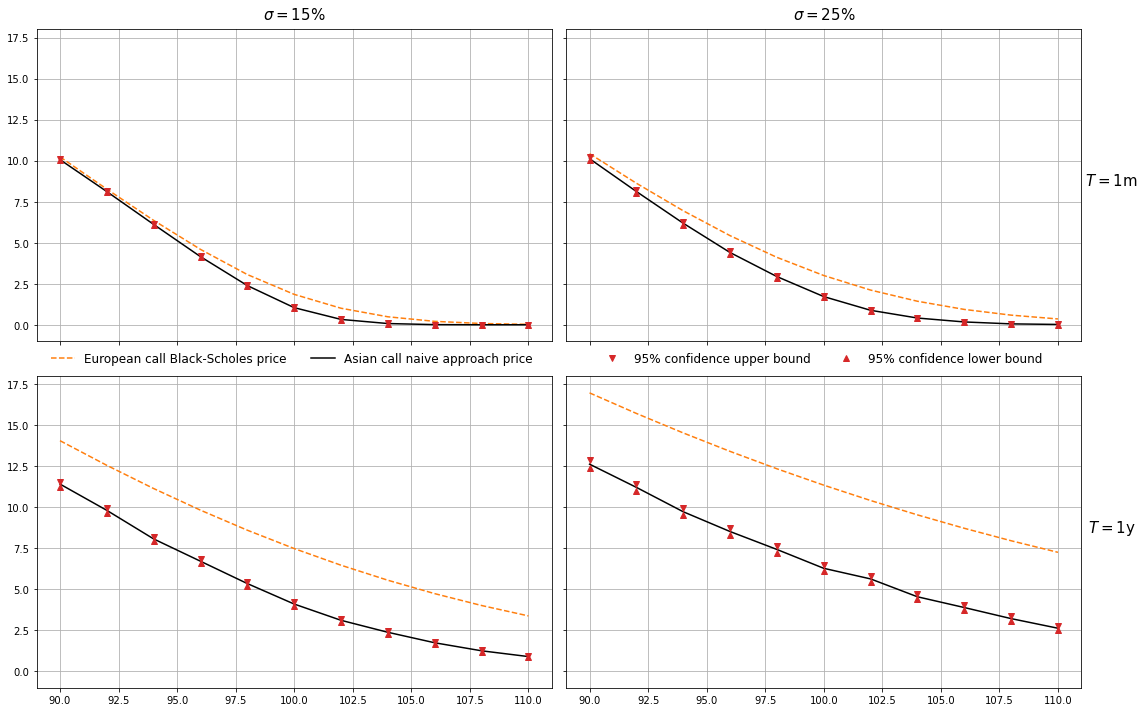

In [127]:
fig = plot_approach(result, Ks, [.15, .25], [1/12, 1])

In [128]:
# fig.savefig(fname='../rapport/charts/prices.png', dpi=300);

## 2. Improved Monte-Carlo

### 2.a Trapezoidal method

In [8]:
def trapeze(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float]:  # returns the estimation and the half-length of the 95% confidence interval
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1).reshape((m + 1, 1))
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    e = s[:-1, ::]*(1 + r*h/2 + dw/2)           # AMENDMENT HERE 
    means = e.mean(axis=0)                      # estimatation of the mean value of the underlying
    c = np.exp(-r*T)*np.maximum(means - K, 0)   # price for each simulation
    return c.mean(), 1.96*c.std()/np.sqrt(n)

In [9]:
# fixed_n, fixed_m, fixed_r, fixed_S0 = 10**4, 50, .03, 100
# Ks = np.linspace(90, 110, 11)

# start = perf_counter()

# result = {}
# for fixed_T in [1/12, 1]:
#     for fixed_sigma in [.15, .25]:
#         fixed = []
#         for K in Ks:
#             est, ci = trapeze(fixed_n, fixed_m, fixed_r, fixed_sigma, K, fixed_T, fixed_S0)
#             bs = vanilla(fixed_r, fixed_sigma, K, fixed_T, fixed_S0)
#             fixed.append([est, bs, ci])
#         fixed = np.array(fixed)
#         result[(fixed_T, fixed_sigma)] = fixed

# dur = perf_counter() - start
# print(f'Duration: {dur:.2f} s')
# plot_approach(result, Ks, [.15, .25], [1/12, 1])

### 2.b Conditional realization of the multiplicative correction factor

In [10]:
def conditional(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float]:  # returns the estimation and the half-length of the 95% confidence interval
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1).reshape((m + 1, 1))
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    rand = np.sqrt(h)*np.random.randn(m, n)/2
    e = s[:-1, ::]*(1 + r*h/2 + dw/2 + rand)    # AMENDMENT HERE 
    means = e.mean(axis=0)                      # estimatation of the mean value of the underlying
    c = np.exp(-r*T)*np.maximum(means - K, 0)   # price for each simulation
    return c.mean(), 1.96*c.std()/np.sqrt(n)

### Results: convergence properties of the three methods

__Problem__: the above chart only shows the statistical error and not the discretization bias. As $\sqrt{n} \sim m$, they should be quite similar.

In [117]:
fixed_n, fixed_r, fixed_K, fixed_T, fixed_sigma, fixed_S0 = 2*10**4, .03, 100, 1, .2, 100

ms_n = np.concatenate([np.linspace(4, 25, 6), np.linspace(40, 256, 15)]).astype('int')
res_n = []

start = perf_counter()
for m in ms_n:
    est, ci = naive(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)
    res_n.append([est, ci])
res_n = np.array(res_n)
end = perf_counter()

print(f'Ran naive method {len(ms_n)} times in {(end - start):.2f} s')

ms_t = np.concatenate([[1, 2], np.linspace(10, 256, 20)]).astype('int')
res_t = []

start = perf_counter()
for m in ms_t:
    est, ci = trapeze(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)
    res_t.append([est, ci])
res_t = np.array(res_t)
end = perf_counter()

print(f'Ran trapeze method {len(ms_t)} times in {(end - start):.2f} s')

ms_3 = np.concatenate([[1, 2], np.linspace(10, 256, 20)]).astype('int')
res_3 = []

start = perf_counter()
for m in ms_3:
    est, ci = conditional(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)
    res_3.append([est, ci])
res_3 = np.array(res_3)
end = perf_counter()

print(f'Ran third method {len(ms_3)} times in {(end - start):.2f} s')

Ran naive method 21 times in 3.19 s
Ran trapeze method 22 times in 3.57 s
Ran third method 22 times in 5.57 s


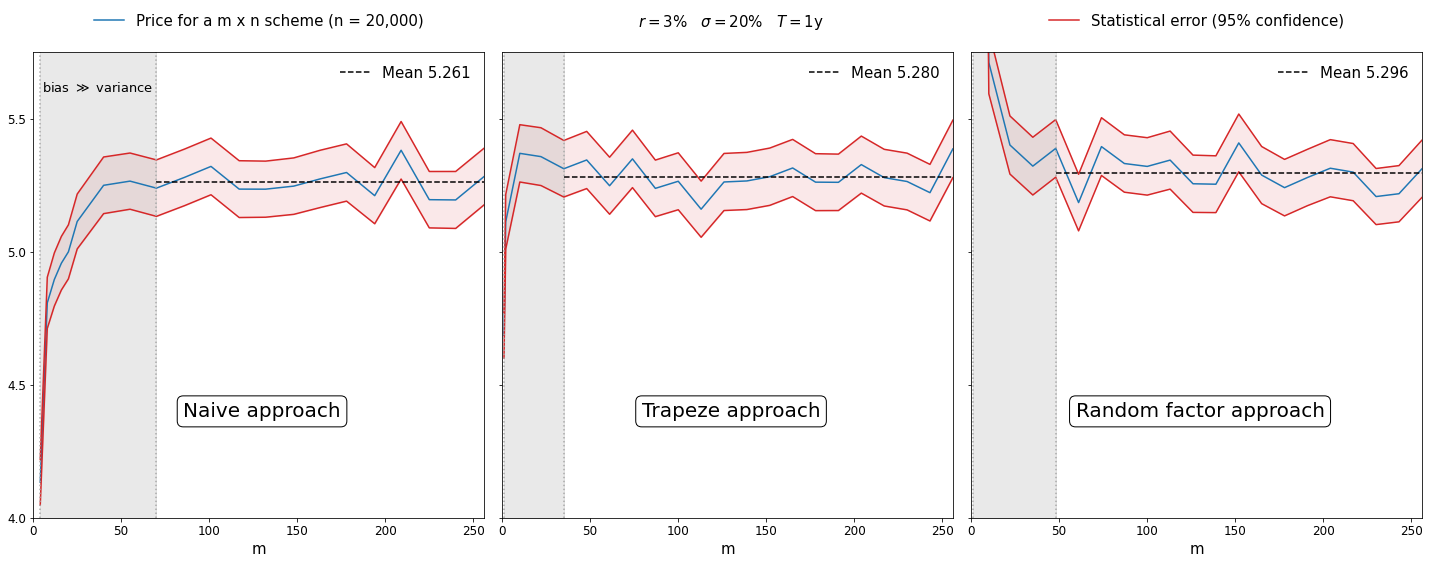

In [118]:
fig, ax = plt.subplots(2, 3, figsize=(20, 8), sharey='row', sharex=True, gridspec_kw={'height_ratios': [.05, 1]})

l1, = ax[1, 0].plot(ms_n, res_n[:, 0])
l2, = ax[1, 0].plot(ms_n, res_n[:, 0] + res_n[:, 1], color='tab:red')
ax[1, 0].plot(ms_n, res_n[:, 0] - res_n[:, 1], color='tab:red')
ax[1, 0].fill_between(ms_n, res_n[:, 0] - res_n[:, 1], res_n[:, 0] + res_n[:, 1], color='tab:red', alpha=.1)
mean_n = np.mean(res_n[-13:, 0])
ax[1, 0].plot(ms_n[-13:], mean_n*np.ones(shape=ms_n[-13:].shape), linestyle='--', color='black', label=f'Mean {mean_n:.3f}')
ax[1, 0].set_xlabel('m', fontsize=15)
ax[1, 0].set_xlim(0, 256)
ax[1, 0].set_ylim(4, 5.75)
ax[1, 0].set_yticks(np.arange(4, 5.6, step=.5), np.arange(4, 5.6, step=.5))
ax[1, 0].plot([4, 4], [4, 6], linestyle=':', color='darkgray')
ax[1, 0].plot([ms_n[-13], ms_n[-13]], [4, 6], linestyle=':', color='darkgray')
ax[1, 0].fill_between([4, ms_n[-13]], [4, 4], [6, 6], color='darkgray', alpha=.25)
ax[1, 0].annotate(text='bias $\gg$ variance', xy=(5, 5.6), size=13)
ax[1, 0].legend(loc='upper right', prop={'size': 15}, frameon=False)

ax[1, 1].plot(ms_t, res_t[:, 0])
ax[1, 1].plot(ms_t, res_t[:, 0] + res_t[:, 1], color='tab:red')
ax[1, 1].plot(ms_t, res_t[:, 0] - res_t[:, 1], color='tab:red')
ax[1, 1].fill_between(ms_t, res_t[:, 0] - res_t[:, 1], res_t[:, 0] + res_t[:, 1], color='tab:red', alpha=.1)
mean_t = np.mean(res_t[4:, 0])
ax[1, 1].plot(ms_t[4:], mean_t*np.ones(shape=ms_t[4:].shape), linestyle='--', color='black', label=f'Mean {mean_t:.3f}')
ax[1, 1].set_xlabel('m', fontsize=15)
ax[1, 1].set_xlim(0, 256)
ax[1, 1].set_ylim(4, 5.75)
ax[1, 1].set_yticks(np.arange(4, 5.6, step=.5), np.arange(4, 5.6, step=.5))
ax[1, 1].plot([1, 1], [4, 6], linestyle=':', color='darkgray')
ax[1, 1].plot([ms_t[4], ms_t[4]], [4, 6], linestyle=':', color='darkgray')
ax[1, 1].fill_between([1, ms_t[4]], [4, 4], [6, 6], color='darkgray', alpha=.25)
ax[1, 1].legend(loc='upper right', prop={'size': 15}, frameon=False)

ax[1, 2].plot(ms_3, res_3[:, 0])
ax[1, 2].plot(ms_3, res_3[:, 0] + res_3[:, 1], color='tab:red')
ax[1, 2].plot(ms_3, res_3[:, 0] - res_3[:, 1], color='tab:red')
ax[1, 2].fill_between(ms_3, res_3[:, 0] - res_3[:, 1], res_3[:, 0] + res_3[:, 1], color='tab:red', alpha=.1)
mean_3 = np.mean(res_3[5:, 0])
ax[1, 2].plot(ms_3[5:], mean_3*np.ones(shape=ms_3[5:].shape), linestyle='--', color='black', label=f'Mean {mean_3:.3f}')
ax[1, 2].set_xlabel('m', fontsize=15)
ax[1, 2].set_xlim(0, 256)
ax[1, 2].set_ylim(4, 5.75)
ax[1, 2].set_yticks(np.arange(4, 5.6, step=.5), np.arange(4, 5.6, step=.5))
ax[1, 2].plot([1, 1], [4, 6], linestyle=':', color='darkgray')
ax[1, 2].plot([ms_3[5], ms_3[5]], [4, 6], linestyle=':', color='darkgray')
ax[1, 2].fill_between([1, ms_3[5]], [4, 4], [6, 6], color='darkgray', alpha=.25)
ax[1, 2].legend(loc='upper right', prop={'size': 15}, frameon=False)

for i in range(3):
    ax[0, i].axis('off')
    for item in ax[1, i].get_xticklabels():
        item.set_fontsize(12)
    for item in ax[1, i].get_yticklabels():
        item.set_fontsize(12)
        

ax[0, 1].set_ylim([0, 3])
ax[0, 1].text(
    x=130,
    y=2.5,
    s=f'$r = 3\%$   $\sigma = 20\%$   $T = 1$y',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=15
)

ax[0, 0].legend([l1], [r'Price for a m x n scheme (n = 20,000)'], frameon=False, prop={'size': 15}, loc='lower center')
ax[0, 2].legend([l2], [r'Statistical error (95% confidence)'], frameon=False, prop={'size': 15}, loc='lower center')

ax[1, 0].text(
    x=130,
    y=4.4,
    s=f'Naive approach',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20,
    bbox=dict(facecolor='none', edgecolor='black', boxstyle='round')
)

ax[1, 1].text(
    x=130,
    y=4.4,
    s=f'Trapeze approach',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20,
    bbox=dict(facecolor='none', edgecolor='black', boxstyle='round')
)

ax[1, 2].text(
    x=130,
    y=4.4,
    s=f'Random factor approach',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20,
    bbox=dict(facecolor='none', edgecolor='black', boxstyle='round')
)

fig.tight_layout();

In [121]:
# fig.savefig(fname='../rapport/charts/cvgce_wo_control.png', dpi=300);

We achieve low bias for low values of $m$, the main focus should be reducing the variance. Hence the control variate approach below.

## 3. Control variates

In [129]:
def control_expectation(
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> float:
    a = (r - sigma**2/2)*T/2
    b = sigma*np.sqrt(T/3)
    rho = K/S0
    xstar = (np.log(rho) - a)/b
    return np.exp(-r*T)*(S0*np.exp(a + b**2/2)*norm.cdf(b - xstar) - K*norm.cdf(-xstar))

In [130]:
# Test (looks good)

control_expectation(.03, .2, 100, 1, 100)

5.086478856771596

In [131]:
def control_coeff(main_var: np.ndarray, control_var: np.ndarray) -> float:
    cov = np.cov([main_var, control_var])
    return - cov[0, 1]/cov[0, 0]

### 3.a With the naive method

In [132]:
def naive_control(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float, float, float, float]: 
    # returns the estimation and the half-length of the 95% confidence interval with and without control
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1).reshape((m + 1, 1))
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    means = s[:-1, ::].mean(axis=0)             # estimatation of the mean value of the underlying
    control_integral = S0*np.exp((r - sigma**2/2)*T/2 + w[:-1, ::].mean(axis=0))
    control = np.exp(-r*T)*np.maximum(control_integral - K, 0)
    c = np.exp(-r*T)*np.maximum(means - K, 0)   # price for each simulation
    expectation = control_expectation(r, sigma, K, T, S0)
    beta = control_coeff(c, control)
    p = c + beta*(control - expectation)
    return p.mean(), 1.96*p.std()/np.sqrt(n), c.mean(), 1.96*c.std()/np.sqrt(n)

### Results

In [ ]:
fixed_n, fixed_r, fixed_K, fixed_T, fixed_sigma, fixed_S0 = 10**4, .03, 100, 1, .2, 100

ms = np.concatenate([np.linspace(4, 25, 6), np.linspace(40, 256, 15)]).astype('int')
fixed = []
for m in ms:
    fixed.append(list(naive_control(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)))
fixed = np.array(fixed)

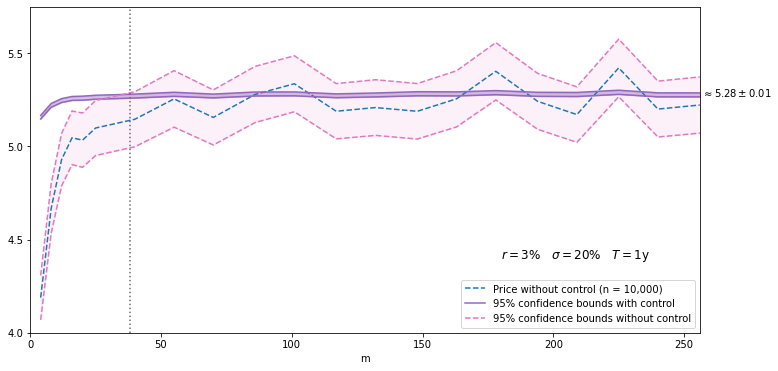

In [166]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ms, fixed[:, 2], label=r'Price without control (n = 10,000)', color='tab:blue', linestyle='--')
ax.plot(ms, fixed[:, 0] + fixed[:, 1], color='tab:purple', label=r'95% confidence bounds with control')
ax.plot(ms, fixed[:, 0] - fixed[:, 1], color='tab:purple')
ax.plot(ms, fixed[:, 2] + fixed[:, 3], color='tab:pink', label=r'95% confidence bounds without control', linestyle='--')
ax.plot(ms, fixed[:, 2] - fixed[:, 3], color='tab:pink', linestyle='--')
ax.fill_between(ms, fixed[:, 2] - fixed[:, 3], fixed[:, 2] + fixed[:, 3], color='tab:pink', alpha=.1)
ax.fill_between(ms, fixed[:, 0] - fixed[:, 1], fixed[:, 0] + fixed[:, 1], color='tab:purple', alpha=.4)
ax.plot([38, 38], [4, 6], color='dimgrey', linestyle=':')
ax.set_xlabel('m')
ax.set_xlim(0, 256)
ax.set_ylim(4, 5.75)
ax.set_yticks(np.arange(4, 5.6, step=.5), np.arange(4, 5.6, step=.5))
mean = np.mean(fixed[ms >= 40, 0])
std = np.mean(fixed[ms >= 40, 1])
ax.annotate(r'$\approx ' + f'{mean:.2f}' + r' \pm ' + f'{std:.2f}$', xy=(1.01, 0.725), xytext=(30, 0),
    xycoords='axes fraction', textcoords='offset points',
    ha='center', va='baseline', fontsize=10
)
ax.legend(loc='lower right')
ax.text(x=180, y=4.4, s=f'$r = 3\%$   $\sigma = 20\%$   $T = 1$y', fontsize=12);

In [167]:
# fig.savefig(fname='../rapport/charts/cvgce_control.png', dpi=300);

The result is truly outstanding: we can take much lower values of $n$ and $m$ and achieve way better performances!

### 3.b With the trapezoidal method

In [19]:
def trapeze_control(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float, float, float]:
    # returns the estimation and the half-length of the 95% confidence interval
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1).reshape((m + 1, 1))
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    e = s[:-1, ::]*(1 + r*h/2 + dw/2)           # AMENDMENT HERE 
    means = e.mean(axis=0)                      # estimatation of the mean value of the underlying
    control_integral = S0*np.exp((r - sigma**2/2)*T/2 + .5*np.mean(w[1:, ::] + w[:-1, ::], axis=0))
    control = np.exp(-r*T)*np.maximum(control_integral - K, 0)
    c = np.exp(-r*T)*np.maximum(means - K, 0)   # price for each simulation
    expectation = control_expectation(r, sigma, K, T, S0)
    beta = control_coeff(c, control)
    p = c + beta*(control - expectation)
    return p.mean(), 1.96*p.std()/np.sqrt(n), c.mean(), 1.96*c.std()/np.sqrt(n)

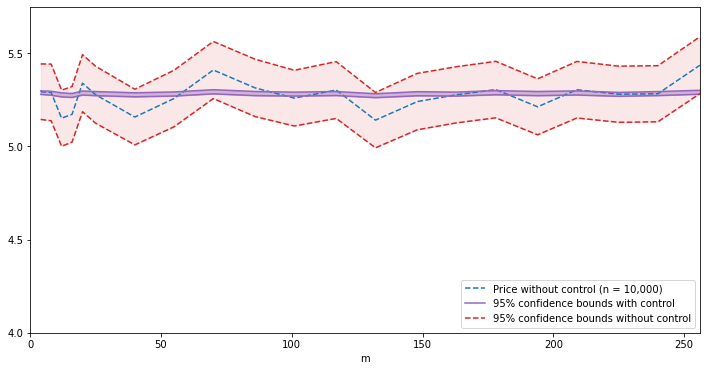

In [20]:
fixed_n, fixed_r, fixed_K, fixed_T, fixed_sigma, fixed_S0 = 10**4, .03, 100, 1, .2, 100

ms = np.concatenate([np.linspace(4, 25, 6), np.linspace(40, 256, 15)]).astype('int')
fixed = []
for m in ms:
    fixed.append(list(trapeze_control(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)))
fixed = np.array(fixed)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ms, fixed[:, 2], label=r'Price without control (n = 10,000)', color='tab:blue', linestyle='--')
ax.plot(ms, fixed[:, 0] + fixed[:, 1], color='tab:purple', label=r'95% confidence bounds with control')
ax.plot(ms, fixed[:, 0] - fixed[:, 1], color='tab:purple')
ax.plot(ms, fixed[:, 2] + fixed[:, 3], color='tab:red', label=r'95% confidence bounds without control', linestyle='--')
ax.plot(ms, fixed[:, 2] - fixed[:, 3], color='tab:red', linestyle='--')
ax.fill_between(ms, fixed[:, 2] - fixed[:, 3], fixed[:, 2] + fixed[:, 3], color='tab:red', alpha=.1)
ax.fill_between(ms, fixed[:, 0] - fixed[:, 1], fixed[:, 0] + fixed[:, 1], color='tab:purple', alpha=.4)
ax.set_xlabel('m')
ax.set_xlim(0, 256)
ax.set_ylim(4, 5.75)
ax.set_yticks(np.arange(4, 5.6, step=.5), np.arange(4, 5.6, step=.5))
# ax.plot([4, 4], [4, 6], linestyle=':', color='darkgray')
# ax.plot([ms[-13], ms[-13]], [4, 6], linestyle=':', color='darkgray')
# ax.fill_between([4, ms[-13]], [4, 4], [6, 6], color='darkgray', alpha=.25)
# ax.annotate(text='bias $\gg$ variance', xy=(18, 5.5))
ax.legend(loc='lower right');

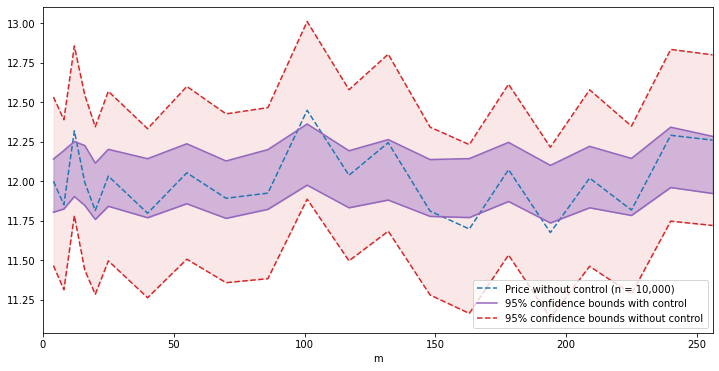

In [21]:
fixed_n, fixed_r, fixed_K, fixed_T, fixed_sigma, fixed_S0 = 10**4, .2, 120, 1, .7, 100

ms = np.concatenate([np.linspace(4, 25, 6), np.linspace(40, 256, 15)]).astype('int')
fixed = []
for m in ms:
    fixed.append(list(trapeze_control(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)))
fixed = np.array(fixed)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ms, fixed[:, 2], label=r'Price without control (n = 10,000)', color='tab:blue', linestyle='--')
ax.plot(ms, fixed[:, 0] + fixed[:, 1], color='tab:purple', label=r'95% confidence bounds with control')
ax.plot(ms, fixed[:, 0] - fixed[:, 1], color='tab:purple')
ax.plot(ms, fixed[:, 2] + fixed[:, 3], color='tab:red', label=r'95% confidence bounds without control', linestyle='--')
ax.plot(ms, fixed[:, 2] - fixed[:, 3], color='tab:red', linestyle='--')
ax.fill_between(ms, fixed[:, 2] - fixed[:, 3], fixed[:, 2] + fixed[:, 3], color='tab:red', alpha=.1)
ax.fill_between(ms, fixed[:, 0] - fixed[:, 1], fixed[:, 0] + fixed[:, 1], color='tab:purple', alpha=.4)
ax.set_xlabel('m')
ax.set_xlim(0, 256)
# ax.set_ylim(4, 5.75)
# ax.set_yticks(np.arange(4, 5.6, step=.5), np.arange(4, 5.6, step=.5))
# ax.plot([4, 4], [4, 6], linestyle=':', color='darkgray')
# ax.plot([ms[-13], ms[-13]], [4, 6], linestyle=':', color='darkgray')
# ax.fill_between([4, ms[-13]], [4, 4], [6, 6], color='darkgray', alpha=.25)
# ax.annotate(text='bias $\gg$ variance', xy=(18, 5.5))
ax.legend(loc='lower right');

### 3.c With the "conditional realization" method